## Imports

In [1]:
from ipynb.fs.full.Jacobian import *

import numpy as np
from numpy import linalg as LA
import sympy as sp

import matplotlib.pyplot as plt
import math

## Global Variables

In [2]:
#Time variables
interval = 10
delta = 0.1

#Numbers represent how far we want to be precised.
Epsilon = 10**-2
Nnewton = 10

## Transitionals functions
### Solver with one equation

In [3]:
"""
    Create the function f wich correspond to this equality : du/dt = expr(u, v). 
    Here du/dt -> un - un-1 / delta
    
    @return: the new function ready to be evaluated.
    
    @var: the symbol we want to evalute (u or v)
    @term_1: the previous term
    @expr: the function tied.
"""

def create_f(var, term_1, expr):
    return (var - term_1)/delta - expr

In [4]:
"""
    Create a list like that : [[t0, u0], [t1, u1], ..., [tn, un]]

    @return: [[t0, u0], [t1, u1], ..., [tn, un]]
    
    @time: [t0, t1, ...]
    @function: [u0, u1, ...]
"""

def result_one_eq(time, function):
    final_points = []
    for i in range(len(function)):
        final_points.append([time[i], function[i]])
        
    return final_points

### Solver with 2 equations

In [14]:
"""
    Same as create_f. The only difference is that this time we 
    keep it in a vector cause we have two different functions.
    
    @return: a vector containing the 2 new functions ready to be evaluated.
    
    @xk_1: previous term
    @f1: first function
    @f2 second function
"""

def create_2_f(xn_1_global, f1, f2):
    return np.array([create_f(u, xn_1_global[0], f1), create_f(v, xn_1_global[1], f2)])

In [6]:
"""
    Create the 2x2 matrix wich correspond to the derivate of F(xk) 
    when xk is vector like xk = (f1, f2).
    This matrix = [df1/du , df2/du]
                  [df1/dv , df2/dv]
    
    @return: new matrix created.
    
    @xk_1: previous term
    @f1: first function
    @f2: second function
"""

def f_prime_2_eqs(xk_1, f1, f2):
    res = np.array([[0, 0], [0, 0]])
    symbols = [u, v]
    tab_f = [f1, f2]
    
    for i in range(2):
        for j in range(2):
            res[i][j] = Jacobian_square_mat(symbols[i], tab_f[j]).subs(symbols[i], xk_1[j])
    
    return res

In [33]:
"""
    Create the term F(xk_1) wich is a vector of size 2 containing the evaluation
    respectivly of f1 and f2.
    
    @return: the term F(xk_1)
    
    @xk_1 previous term
    @fu: first expression in the inital system.
    @fv: second expr in the initial system.
    @vec_f: list containing f1 and f2
    @i: index to recup the correct previous term of the function.
"""

def create_fxk_1(xk_1, vec_f):
    res = np.array([0, 0])
    for i in range(2):
        res[i] = vec_f[i].evalf(subs={u: xk_1[0], v: xk_1[1]})
    
    return res

In [8]:
"""
    Create a list containings the lists of points to build the u function
    and the v function.
    
    @return: [ [ [t0, u0], [t1, u1], ..., [tn, un] ] , [ [t0, v0], [t1, v1], ..., [tn, vn] ] ]
    
    @time: list containing t0, t1, t2, ...
    @fu: list containing u0, u1, u2, ...
    @fv: list containing v0, v1, v2, ...
"""

def result_2_eq(time, fu, fv):
    #Creation of our final list containing tuples like that: (time, function)
    final_points_u = []
    final_points_v = []
    
    for i in range(len(fu)):
        final_points_u.append([time[i], fu[i]])
        final_points_v.append([time[i], fv[i]])
        
    return [final_points_u, final_points_v]

## Solver for one differencial equation

In [9]:
def Solver_one_equation(expr, u0):
    t0 = 0
    i = 1
    f_uk = 1
    uk_1 = u0
    nb = 0
    
    #Each list is an axis.
    #Time = [t0, t1, t2, ...., tn]
    #Function = [u0, u1, u2, ...., un]
    function = [u0]
    time = [t0]
    
    first = True
    
    #Loop for the time
    while(t0 < interval):
        t0 += delta
        nb = 0
        #Newton's method
        while(f_uk > Epsilon or nb < Nnewton):
            
            f_uk_1 = 0
            f_uk_1_prime = 0
            
            # First step, we change our equation to f(x) = 0
            f = create_f(u, uk_1, expr)
            
            # We recup the term f(uk-1)
            if(first):
                f_uk_1 = f.subs(u, uk_1)
                first = False
            
            else:
                f_uk_1 = f.subs(u, function[i-1])
            
            #We recup the term f'(uk_1)
            f_uk_1_prime = Jacobian_one(f).subs(u, uk_1)

            #Formula : uk = uk_1 - (f(uk_1) / f'(uk_1))
            uk = uk_1 - (f_uk_1 / f_uk_1_prime)

            #Check the approximation. If f_uk < Epsilon = good approximation
            f_uk = f.subs(u, uk)
            
            uk_1 = uk
            if(f_uk < Epsilon):
                break
        
        #Update our 2 lists and indexes.
        time.append(t0)
        function.append(uk)
        f_uk = 1
        i += 1
        nb += 1

    return result_one_eq(time, function)

## Solver for 2 differentials equations

In [38]:
def Solver_two_equations(u0, v0, f1, f2):
    t0 = 0
    f_xk = 1
    uk_1 = u0
    vk_1 = v0
    xk_1 = np.array([u0, v0])
    xn_1_global = np.array([u0, v0])
    
    #Each list is an axis.
    #Time = [t0, t1, t2, ...., tn]
    #Functions = [u0, u1, u2, ...., un]
    fu = [u0]
    fv = [v0]
    time = [t0]
    
    #Loop for the time
    while(t0 < interval):
        t0 += delta
        nb = 0
        
        #Newton's method
        while(nb < Nnewton):
            nb+=1
            
            # First step, we change our equation to F(x) = 0
            vec_f = create_2_f(xn_1_global, f1, f2)
            
            #Creating F(xk-1)
            F_xk_1 = create_fxk_1(xk_1, vec_f)
            
            #Creating F'(xk-1)
            F_xk_1_prime = f_prime_2_eqs(xk_1, vec_f[0], vec_f[1])
            print("vec_f = ", end='')
            print(vec_f)
            print("fxk_1 = ", end='')
            print(F_xk_1)
            #print("f'xk_1 = ", end='')
            #print(F_xk_1_prime)
            
            #print(LA.inv(F_xk_1_prime))
            #print(np.dot(F_xk_1, LA.inv(F_xk_1_prime)))
            
            #Formula : xk = xk_1 - tr(F'(xk_1)) * F(xk_1)
            xk = xk_1 - np.dot(LA.inv(F_xk_1_prime), F_xk_1)
            print("xk = ", end='')
            print(xk)
            #Check the approximation. If f_uk < Epsilon = good approximation
            f_xk = LA.norm(xk - xn_1_global)
            print("f_xk = ", end='')
            print(f_xk)
            #print("nb = ", end='')
            #print(nb)
            
            if(f_xk < Epsilon):
                break
            
            xk_1 = xk
        
        #Update our 2 lists and indexes.
        print("xk append")
        time.append(t0)
        fu.append(xk[0])
        fv.append(xk[1])
        
        xn_1_global = np.array([xk[0],xk[1]])
        f_xk = 1        
      
    return result_2_eq(time, fu, fv)

## Unitary tests
### Tests with only one equation.
### exp(-x)

In [11]:
a = np.matrix([[11, 1], [-1, 9]])
LA.inv(a)

matrix([[ 0.09, -0.01],
        [ 0.01,  0.11]])

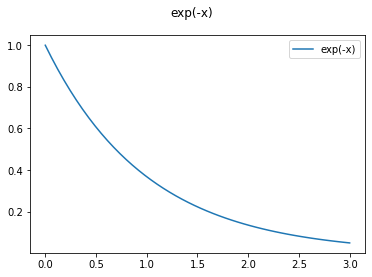

[[0, 1], [0.1, 0.909090909090909], [0.2, 0.826446280991735], [0.30000000000000004, 0.751314800901578], [0.4, 0.683013455365071], [0.5, 0.620921323059155], [0.6, 0.564473930053777], [0.7, 0.513158118230707], [0.7999999999999999, 0.466507380209733], [0.8999999999999999, 0.424097618372485], [0.9999999999999999, 0.385543289429532], [1.0999999999999999, 0.350493899481392], [1.2, 0.318630817710357], [1.3, 0.289664379736688], [1.4000000000000001, 0.263331254306080], [1.5000000000000002, 0.239392049369164], [1.6000000000000003, 0.217629135790149], [1.7000000000000004, 0.197844668900135], [1.8000000000000005, 0.179858789909214], [1.9000000000000006, 0.163507990826558], [2.0000000000000004, 0.148643628024144], [2.1000000000000005, 0.135130570931040], [2.2000000000000006, 0.122845973573672], [2.3000000000000007, 0.111678157794248], [2.400000000000001, 0.101525597994771], [2.500000000000001, 0.0922959981770642], [2.600000000000001, 0.0839054528882402], [2.700000000000001, 0.0762776844438547], [2.8

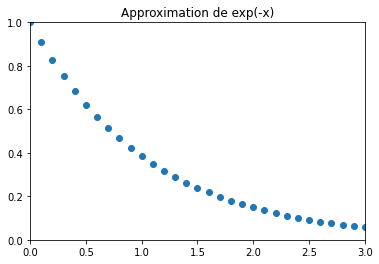

In [12]:
fig, ax = plt.subplots()
x = np.linspace(0, 3, 50)
y = np.exp(-x)
ax.plot(x, y, label ='exp(-x)')
plt.legend()  
plt.suptitle('exp(-x)')
plt.show()

res = Solver_one_equation(-u, 1)
print(res)

absi = []
for i in range(0, len(res)):
    absi.append(res[i][0])
coords = []
for j in range(0, len(res)):
    coords.append(res[j][1])
    
plt.ylim([0, 1])
plt.title('Approximation de exp(-x)')
plt.xlim([0, 3])
plt.scatter(absi, coords)

### exp(x)

## Tests with 2 equations


vec_f = [11.0*u - v - 20.0 u + 9.0*v - 10.0]
fxk_1 = [1 1]
xk = [1.92 0.88]
f_xk = 0.14422205101855962
vec_f = [11.0*u - v - 20.0 u + 9.0*v - 10.0]
fxk_1 = [0 0]
xk = [1.92 0.88]
f_xk = 0.14422205101855962
vec_f = [11.0*u - v - 20.0 u + 9.0*v - 10.0]
fxk_1 = [0 0]
xk = [1.92 0.88]
f_xk = 0.14422205101855962
vec_f = [11.0*u - v - 20.0 u + 9.0*v - 10.0]
fxk_1 = [0 0]
xk = [1.92 0.88]
f_xk = 0.14422205101855962
vec_f = [11.0*u - v - 20.0 u + 9.0*v - 10.0]
fxk_1 = [0 0]
xk = [1.92 0.88]
f_xk = 0.14422205101855962
vec_f = [11.0*u - v - 20.0 u + 9.0*v - 10.0]
fxk_1 = [0 0]
xk = [1.92 0.88]
f_xk = 0.14422205101855962
vec_f = [11.0*u - v - 20.0 u + 9.0*v - 10.0]
fxk_1 = [0 0]
xk = [1.92 0.88]
f_xk = 0.14422205101855962
vec_f = [11.0*u - v - 20.0 u + 9.0*v - 10.0]
fxk_1 = [0 0]
xk = [1.92 0.88]
f_xk = 0.14422205101855962
vec_f = [11.0*u - v - 20.0 u + 9.0*v - 10.0]
fxk_1 = [0 0]
xk = [1.92 0.88]
f_xk = 0.14422205101855962
vec_f = [11.0*u - v - 20.0 u + 9.0*v - 10.0]
fxk_1 = [0 0]
xk = [1.92 0.8

fxk_1 = [0 0]
xk = [ 0.88 -0.68]
f_xk = 0.14422205101855953
vec_f = [11.0*u - v - 9.59999999999999 u + 9.0*v + 5.6]
fxk_1 = [0 0]
xk = [ 0.88 -0.68]
f_xk = 0.14422205101855953
vec_f = [11.0*u - v - 9.59999999999999 u + 9.0*v + 5.6]
fxk_1 = [0 0]
xk = [ 0.88 -0.68]
f_xk = 0.14422205101855953
vec_f = [11.0*u - v - 9.59999999999999 u + 9.0*v + 5.6]
fxk_1 = [0 0]
xk = [ 0.88 -0.68]
f_xk = 0.14422205101855953
vec_f = [11.0*u - v - 9.59999999999999 u + 9.0*v + 5.6]
fxk_1 = [0 0]
xk = [ 0.88 -0.68]
f_xk = 0.14422205101855953
xk append
vec_f = [11.0*u - v - 8.79999999999999 u + 9.0*v + 6.8]
fxk_1 = [1 1]
xk = [ 0.8 -0.8]
f_xk = 0.14422205101855953
vec_f = [11.0*u - v - 8.79999999999999 u + 9.0*v + 6.8]
fxk_1 = [0 0]
xk = [ 0.8 -0.8]
f_xk = 0.14422205101855953
vec_f = [11.0*u - v - 8.79999999999999 u + 9.0*v + 6.8]
fxk_1 = [0 0]
xk = [ 0.8 -0.8]
f_xk = 0.14422205101855953
vec_f = [11.0*u - v - 8.79999999999999 u + 9.0*v + 6.8]
fxk_1 = [0 0]
xk = [ 0.8 -0.8]
f_xk = 0.14422205101855953
vec_f = [1

vec_f = [11.0*u - v + 5.20000000000001 u + 9.0*v + 22.8]
fxk_1 = [0 0]
xk = [-0.6 -2.4]
f_xk = 0.14422205101855964
vec_f = [11.0*u - v + 5.20000000000001 u + 9.0*v + 22.8]
fxk_1 = [0 0]
xk = [-0.6 -2.4]
f_xk = 0.14422205101855964
vec_f = [11.0*u - v + 5.20000000000001 u + 9.0*v + 22.8]
fxk_1 = [0 0]
xk = [-0.6 -2.4]
f_xk = 0.14422205101855964
vec_f = [11.0*u - v + 5.20000000000001 u + 9.0*v + 22.8]
fxk_1 = [0 0]
xk = [-0.6 -2.4]
f_xk = 0.14422205101855964
vec_f = [11.0*u - v + 5.20000000000001 u + 9.0*v + 22.8]
fxk_1 = [0 0]
xk = [-0.6 -2.4]
f_xk = 0.14422205101855964
vec_f = [11.0*u - v + 5.20000000000001 u + 9.0*v + 22.8]
fxk_1 = [0 0]
xk = [-0.6 -2.4]
f_xk = 0.14422205101855964
vec_f = [11.0*u - v + 5.20000000000001 u + 9.0*v + 22.8]
fxk_1 = [0 0]
xk = [-0.6 -2.4]
f_xk = 0.14422205101855964
vec_f = [11.0*u - v + 5.20000000000001 u + 9.0*v + 22.8]
fxk_1 = [0 0]
xk = [-0.6 -2.4]
f_xk = 0.14422205101855964
vec_f = [11.0*u - v + 5.20000000000001 u + 9.0*v + 22.8]
fxk_1 = [0 0]
xk = [-0.

xk = [-2.27 -4.03]
f_xk = 0.21400934559032656
vec_f = [11.0*u - v + 21.0 u + 9.0*v + 39.0]
fxk_1 = [0 0]
xk = [-2.27 -4.03]
f_xk = 0.21400934559032656
vec_f = [11.0*u - v + 21.0 u + 9.0*v + 39.0]
fxk_1 = [0 0]
xk = [-2.27 -4.03]
f_xk = 0.21400934559032656
vec_f = [11.0*u - v + 21.0 u + 9.0*v + 39.0]
fxk_1 = [0 0]
xk = [-2.27 -4.03]
f_xk = 0.21400934559032656
vec_f = [11.0*u - v + 21.0 u + 9.0*v + 39.0]
fxk_1 = [0 0]
xk = [-2.27 -4.03]
f_xk = 0.21400934559032656
vec_f = [11.0*u - v + 21.0 u + 9.0*v + 39.0]
fxk_1 = [0 0]
xk = [-2.27 -4.03]
f_xk = 0.21400934559032656
xk append
vec_f = [11.0*u - v + 22.7 u + 9.0*v + 40.3]
fxk_1 = [1 1]
xk = [-2.35 -4.15]
f_xk = 0.1442220510185597
vec_f = [11.0*u - v + 22.7 u + 9.0*v + 40.3]
fxk_1 = [0 0]
xk = [-2.35 -4.15]
f_xk = 0.1442220510185597
vec_f = [11.0*u - v + 22.7 u + 9.0*v + 40.3]
fxk_1 = [0 0]
xk = [-2.35 -4.15]
f_xk = 0.1442220510185597
vec_f = [11.0*u - v + 22.7 u + 9.0*v + 40.3]
fxk_1 = [0 0]
xk = [-2.35 -4.15]
f_xk = 0.1442220510185597
vec

vec_f = [11.0*u - v + 39.4 u + 9.0*v + 56.6]
fxk_1 = [0 0]
xk = [-4.02 -5.78]
f_xk = 0.1442220510185597
vec_f = [11.0*u - v + 39.4 u + 9.0*v + 56.6]
fxk_1 = [0 0]
xk = [-4.02 -5.78]
f_xk = 0.1442220510185597
vec_f = [11.0*u - v + 39.4 u + 9.0*v + 56.6]
fxk_1 = [0 0]
xk = [-4.02 -5.78]
f_xk = 0.1442220510185597
vec_f = [11.0*u - v + 39.4 u + 9.0*v + 56.6]
fxk_1 = [0 0]
xk = [-4.02 -5.78]
f_xk = 0.1442220510185597
vec_f = [11.0*u - v + 39.4 u + 9.0*v + 56.6]
fxk_1 = [0 0]
xk = [-4.02 -5.78]
f_xk = 0.1442220510185597
vec_f = [11.0*u - v + 39.4 u + 9.0*v + 56.6]
fxk_1 = [0 0]
xk = [-4.02 -5.78]
f_xk = 0.1442220510185597
vec_f = [11.0*u - v + 39.4 u + 9.0*v + 56.6]
fxk_1 = [0 0]
xk = [-4.02 -5.78]
f_xk = 0.1442220510185597
vec_f = [11.0*u - v + 39.4 u + 9.0*v + 56.6]
fxk_1 = [0 0]
xk = [-4.02 -5.78]
f_xk = 0.1442220510185597
vec_f = [11.0*u - v + 39.4 u + 9.0*v + 56.6]
fxk_1 = [0 0]
xk = [-4.02 -5.78]
f_xk = 0.1442220510185597
xk append
vec_f = [11.0*u - v + 40.2 u + 9.0*v + 57.8]
fxk_1 = [

vec_f = [11.0*u - v + 55.2 u + 9.0*v + 72.8]
fxk_1 = [0 0]
xk = [-5.69 -7.41]
f_xk = 0.21400934559032683
vec_f = [11.0*u - v + 55.2 u + 9.0*v + 72.8]
fxk_1 = [0 0]
xk = [-5.69 -7.41]
f_xk = 0.21400934559032683
vec_f = [11.0*u - v + 55.2 u + 9.0*v + 72.8]
fxk_1 = [0 0]
xk = [-5.69 -7.41]
f_xk = 0.21400934559032683
vec_f = [11.0*u - v + 55.2 u + 9.0*v + 72.8]
fxk_1 = [0 0]
xk = [-5.69 -7.41]
f_xk = 0.21400934559032683
vec_f = [11.0*u - v + 55.2 u + 9.0*v + 72.8]
fxk_1 = [0 0]
xk = [-5.69 -7.41]
f_xk = 0.21400934559032683
vec_f = [11.0*u - v + 55.2 u + 9.0*v + 72.8]
fxk_1 = [0 0]
xk = [-5.69 -7.41]
f_xk = 0.21400934559032683
xk append
vec_f = [11.0*u - v + 56.9 u + 9.0*v + 74.1]
fxk_1 = [1 1]
xk = [-5.77 -7.53]
f_xk = 0.1442220510185597
vec_f = [11.0*u - v + 56.9 u + 9.0*v + 74.1]
fxk_1 = [0 0]
xk = [-5.77 -7.53]
f_xk = 0.1442220510185597
vec_f = [11.0*u - v + 56.9 u + 9.0*v + 74.1]
fxk_1 = [0 0]
xk = [-5.77 -7.53]
f_xk = 0.1442220510185597
vec_f = [11.0*u - v + 56.9 u + 9.0*v + 74.1]
fxk

xk = [-7.1 -8.9]
f_xk = 0.14422205101855898
xk append
vec_f = [11.0*u - v + 71.0 u + 9.0*v + 88.9999999999999]
fxk_1 = [1 1]
xk = [-7.18 -9.02]
f_xk = 0.14422205101855898
vec_f = [11.0*u - v + 71.0 u + 9.0*v + 88.9999999999999]
fxk_1 = [1 0]
xk = [-7.27 -9.03]
f_xk = 0.2140093455903263
vec_f = [11.0*u - v + 71.0 u + 9.0*v + 88.9999999999999]
fxk_1 = [0 0]
xk = [-7.27 -9.03]
f_xk = 0.2140093455903263
vec_f = [11.0*u - v + 71.0 u + 9.0*v + 88.9999999999999]
fxk_1 = [0 0]
xk = [-7.27 -9.03]
f_xk = 0.2140093455903263
vec_f = [11.0*u - v + 71.0 u + 9.0*v + 88.9999999999999]
fxk_1 = [0 0]
xk = [-7.27 -9.03]
f_xk = 0.2140093455903263
vec_f = [11.0*u - v + 71.0 u + 9.0*v + 88.9999999999999]
fxk_1 = [0 0]
xk = [-7.27 -9.03]
f_xk = 0.2140093455903263
vec_f = [11.0*u - v + 71.0 u + 9.0*v + 88.9999999999999]
fxk_1 = [0 0]
xk = [-7.27 -9.03]
f_xk = 0.2140093455903263
vec_f = [11.0*u - v + 71.0 u + 9.0*v + 88.9999999999999]
fxk_1 = [0 0]
xk = [-7.27 -9.03]
f_xk = 0.2140093455903263
vec_f = [11.0*u -

vec_f = [11.0*u - v + 80.2 u + 9.0*v + 97.7999999999999]
fxk_1 = [1 1]
xk = [-8.1 -9.9]
f_xk = 0.14422205101855898
vec_f = [11.0*u - v + 80.2 u + 9.0*v + 97.7999999999999]
fxk_1 = [0 0]
xk = [-8.1 -9.9]
f_xk = 0.14422205101855898
vec_f = [11.0*u - v + 80.2 u + 9.0*v + 97.7999999999999]
fxk_1 = [0 0]
xk = [-8.1 -9.9]
f_xk = 0.14422205101855898
vec_f = [11.0*u - v + 80.2 u + 9.0*v + 97.7999999999999]
fxk_1 = [0 0]
xk = [-8.1 -9.9]
f_xk = 0.14422205101855898
vec_f = [11.0*u - v + 80.2 u + 9.0*v + 97.7999999999999]
fxk_1 = [0 0]
xk = [-8.1 -9.9]
f_xk = 0.14422205101855898
vec_f = [11.0*u - v + 80.2 u + 9.0*v + 97.7999999999999]
fxk_1 = [0 0]
xk = [-8.1 -9.9]
f_xk = 0.14422205101855898
vec_f = [11.0*u - v + 80.2 u + 9.0*v + 97.7999999999999]
fxk_1 = [0 0]
xk = [-8.1 -9.9]
f_xk = 0.14422205101855898
vec_f = [11.0*u - v + 80.2 u + 9.0*v + 97.7999999999999]
fxk_1 = [0 0]
xk = [-8.1 -9.9]
f_xk = 0.14422205101855898
vec_f = [11.0*u - v + 80.2 u + 9.0*v + 97.7999999999999]
fxk_1 = [0 0]
xk = [-8.

xk = [ -9.77 -11.53]
f_xk = 0.2140093455903263
vec_f = [11.0*u - v + 96.0 u + 9.0*v + 114.0]
fxk_1 = [0 0]
xk = [ -9.77 -11.53]
f_xk = 0.2140093455903263
vec_f = [11.0*u - v + 96.0 u + 9.0*v + 114.0]
fxk_1 = [0 0]
xk = [ -9.77 -11.53]
f_xk = 0.2140093455903263
vec_f = [11.0*u - v + 96.0 u + 9.0*v + 114.0]
fxk_1 = [0 0]
xk = [ -9.77 -11.53]
f_xk = 0.2140093455903263
vec_f = [11.0*u - v + 96.0 u + 9.0*v + 114.0]
fxk_1 = [0 0]
xk = [ -9.77 -11.53]
f_xk = 0.2140093455903263
vec_f = [11.0*u - v + 96.0 u + 9.0*v + 114.0]
fxk_1 = [0 0]
xk = [ -9.77 -11.53]
f_xk = 0.2140093455903263
vec_f = [11.0*u - v + 96.0 u + 9.0*v + 114.0]
fxk_1 = [0 0]
xk = [ -9.77 -11.53]
f_xk = 0.2140093455903263
vec_f = [11.0*u - v + 96.0 u + 9.0*v + 114.0]
fxk_1 = [0 0]
xk = [ -9.77 -11.53]
f_xk = 0.2140093455903263
vec_f = [11.0*u - v + 96.0 u + 9.0*v + 114.0]
fxk_1 = [0 0]
xk = [ -9.77 -11.53]
f_xk = 0.2140093455903263
xk append
[[0, 2], [0.1, 1.92], [0.2, 1.8399999999999999], [0.30000000000000004, 1.75999999999999

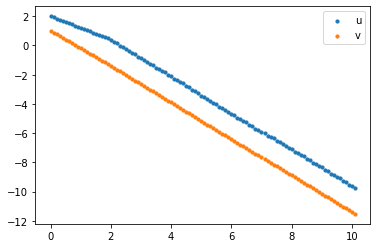

In [39]:
u0 = 2
v0 = 1

du = -u + v
dv = v - u

res = Solver_two_equations(u0, v0, du, dv)
print(res[0])
print("-------")
print(res[1])

time = []
coords_u = []
coords_v = []

for i in range(0, len(res[0])):
    time.append(res[0][i][0])
    coords_u.append(res[0][i][1])
    coords_v.append(res[1][i][1])

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(time, coords_u, s=10, label='u')
ax1.scatter(time, coords_v, s=10, label='v')
plt.legend(loc='upper right');
plt.show()
